$$ \\ $$
2.1:
$$ \\ $$
When using an $\epsilon$-greedy action selection criterion, in the case of two actions and $\epsilon = 0.5$, actions would be selected at random half of the time.  Of the times when actions are selected at random, the greedy action will be select half of the time.  Meaning the greedy action will be selected a total of $75\%$ of the time.
$$ \\ $$
2.2:
$$ \\ $$
Given that all of the reward estimates are initialized to 0, the first action will be selected arbitrarily, possible at random.
$$ \\ $$
The following actions must have been selected at random as a result of the $\epsilon$ case: $A_2$, $A_5$.
$$ \\ $$
This can be demonstrated by observing that $Q_1(1) = 1 > Q_1(2) = 0$ and $Q_4(2) = \frac{R_2 + R_3 + R_4}{3} = \frac{5}{3} > Q_4(3) = 0$.
$$ \\ $$
Regarding the question of when random $\epsilon$ selection could have occured, it could have occured at any time step after the first.
$$ \\ $$
2.3:
$$ \\ $$
In the long run $\epsilon=0.01$ will achieve the highest cumulative reward and probability of selecting the correct answer.  The disadvantage of $\epsilon=0.01$ relative to $\epsilon=0.1$ is that it will cause our agent to take longer to find the optimal action, but it will select that action more consistently once it has been found.
$$ \\ $$
The optimal action has a reward of $1.55$. The expected reward per action once the agent has found the best possible action is equal to the sum of the greedy case and the $\epsilon$ random case:  $1.55 (1 - \epsilon) + \epsilon \sum^{10}_{i=1}\frac{q_*(i)}{10}$.
$$ \\ $$
So the difference between the expected long term reward per action in the $\epsilon = .01$ and $\epsilon = .1$ cases is $1.55(.1 - .01) = 0.1395$.
$$ \\ $$
2.4:
$$ \\ $$
If $\alpha$ is not constant, but instead varies with with each update step $n$, then our incremental update rule utilizing $\alpha_n$ can be expressed as follows:
$$ \\ $$
\begin{align} 
Q_{n+1} & = Q_n + \alpha_n [R_n - Q_n] \\
& = \alpha_n R_n + (1 - \alpha_n) Q_n \\
& = \alpha_n R_n + (1 - \alpha_n) (\alpha_{n-1}R_{n-1} + (1 - \alpha_{n-1})Q_{n-1})  \\
& = \alpha_n R_n + (1 - \alpha_n)\alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1})(Q_{n-2} + \alpha_{n-2}[R_{n-2} - Q_{n-2}]) \\
& = \alpha_n R_n + (1 - \alpha_n)\alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1})((1 - \alpha_{n-2})Q_{n-2} + \alpha_{n-2}R_{n-2})) \\
& = \alpha_n R_n + (1 - \alpha_n)\alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1})\alpha_{n-2}R_{n-2} +  \\ 
& ...  +  Q_1 \prod_{i=1}^n(1 - \alpha_i) + \alpha_{1} R_1 \prod_{j = 1}^{n - 1} (1 - \alpha_{n - j + 1}) \\
& = Q_1 \prod_{i=1}^n(1 - \alpha_i) + \alpha_n R_n + \sum^{n - 1}_{i = 1}\alpha_{i} R_i \prod_{j = 1}^{n - i} (1 - \alpha_{n - j + 1})
\end{align}
$$ \\ $$
2.5:

In [70]:
%matplotlib inline

import numpy as np
import random
import math
import numpy.random
from enum import Enum
import matplotlib.pyplot as plt

# EXERCISE 2.5

runs = 2000

methods = Enum("BanditMethod", "SAMPLE_AVERAGE EPSILON_GREEDY UCB GRADIENT_BANDIT OPTIMISTIC_GREEDY")

"""
returns data in the format

{
    "rewards": np.array([1.5, .2, ...]),
    "optimal": np.array([1, 0, ...])
}
""" 
def ten_armed_bandit(steps, method = methods.EPSILON_GREEDY, constant_alpha = .1, Q0 = 0.0, c = 0):
    q = np.zeros(10, dtype = np.dtype("float64"))
    Q = np.array(list(map(lambda x : Q0, range(10))), dtype = np.dtype("float64"))
    N_a = np.zeros(10)
    
    rewards = []
    optimal = []
    
    if method == methods.UCB:
        def reward_evaluator(a, t):
            N_a[a] = N_a[a] + 1
            return Q[a] + c * ((math.log(t + 1)/N_a[a])**.5)
        
    else:
        def reward_evaluator(a, t):
            return Q[a]
    

    for i in range(steps):
        arg_max_reward = None
        arg_max_actions = []
        
        for j in range(len(Q)):
            estimated_reward = reward_evaluator(j, i)
                        
            if arg_max_reward == None or estimated_reward > arg_max_reward:
                arg_max_reward = estimated_reward
                arg_max_actions = [j]
                
            elif estimated_reward == arg_max_reward:
                arg_max_actions.append(j)
                    
        print('loc4:' + str(method))
        if (method in [methods.SAMPLE_AVERAGE, methods.EPSILON_GREEDY]) and random.uniform(0, 1) < .1:
            print('loc3')
            selected_action = random.choice(range(10))
        else:
            selected_action = random.choice(arg_max_actions)
                    
        actual_reward = q[selected_action]
        # not being set to constant correctly for epsilon_greedy
        alpha = 1/(i + 1) if (method in [methods.SAMPLE_AVERAGE, methods.UCB, methods.GRADIENT_BANDIT]) else constant_alpha
       
        print('loc8:' + str(selected_action))
        if actual_reward != 0:
            print("loc2:" + str(q[selected_action]))
            print("loc6:" + str(Q[selected_action] + alpha * (actual_reward - Q[selected_action])))
            print("loc6.5" + str(type(Q[selected_action] + alpha * (actual_reward - Q[selected_action]))))
            print("loc7:" + str(alpha))
        # FIXME this is growing too large in epsilon greedy case
        # FIXME float64 being coerced into int64
        Q[selected_action] = Q[selected_action] + alpha * (actual_reward - Q[selected_action])
        print("loc1:" + str(Q[selected_action]))
        print("loc1.5:" + str(type(Q[selected_action])))
        
        was_action_optimal = 1 if actual_reward == max(q) else 0
            
        rewards.append(actual_reward)
        optimal.append(was_action_optimal)
        
        random_walk_values = np.random.normal(0, .01, len(q))
        
        for j in range(len(q)):
            q[j] = q[j] + random_walk_values[j]
                 
    return {
        "rewards": np.array(rewards),
        "optimal": np.array(optimal)
    }


def average_bandit_results(sample_average = False, steps = 10000):
    rewards = np.zeros(steps)
    optimal = np.zeros(steps)
    method = methods.SAMPLE_AVERAGE if sample_average else methods.EPSILON_GREEDY 
    
    for i in range(runs):
        results = ten_armed_bandit(steps, method = method)
        rewards = rewards + (results["rewards"] / runs)
        optimal = optimal + (results["optimal"] / runs)    
    
    return {
        "rewards": rewards,
        "optimal": optimal
    }

def plot_average_rewards(with_sample_average, without_sample_average):
    plt.plot(with_sample_average, "r--", label = "sample average")
    plt.plot(without_sample_average, "g", label = "constant")
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()
    plt.show()
    
def plot_average_optimality(with_sample_average, without_sample_average):
    plt.plot(with_sample_average, "r--", label = "sample average")
    plt.plot(without_sample_average, "g", label = "constant")
    plt.xlabel("steps")
    plt.ylabel("percent optimal")
    plt.legend()
    plt.show()

In [ ]:
with_sample_average = average_bandit_results(True)

In [148]:
without_sample_average = average_bandit_results()

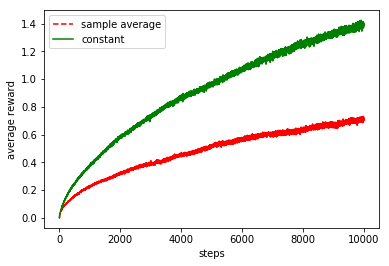

In [149]:
plot_average_rewards(with_sample_average["rewards"], without_sample_average["rewards"])

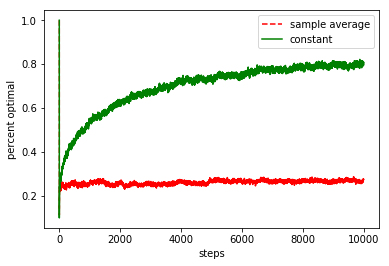

In [150]:
plot_average_optimality(with_sample_average["optimal"], without_sample_average["optimal"])

2.6: 
$$ \\ $$
The optimistic greedy agent's initial spike in rewards can be explained as follows.
$$ \\ $$
$q_{*}(a)$ is normally distributed with a mean of $0$ and a variance of $1$.  This means $Q_1 > max\{q_{*}(a)\}$ in the vast majority of cases.  
$$ \\ $$
For the reward distributions where the above is true, agents with the optimistic greedy action-value method will attempt every action at least once at the onset.  
$$ \\ $$
The spike we observe is a product of agents selecting the optimal action once during this preliminary period.
$$ \\ $$
2.7:
$$ \\ $$
The softmax distribution with two actions consist of,
$$ \\ \pi_t(a) = \frac{e^{H_t(a)}}{e^{H_t(1)} + e^{H_t(2)}}. \\ $$
Logistic classifiers are binary classifiers.  In this case let $L(a)$ represent the probability assigned by a logistic classifier of selecting $a$, where $a \in \{ 1 , 2 \}$.  $L(2)$ is formulated as,
$$ \\ L(2) = \frac{1}{1+ e^{- f(2)} } \\ $$
where $f(a)$ is a function which accepts an action and outputs a preference score.  In the case of the softmax distribution, the probability of selection action $a=2$ is,
\begin{align}
\pi_t(2) &= \frac{e^{H_t(2)}}{e^{H_t(1)} + e^{H_t(2)}} \\
&= \frac{1}{1 + e^{H_t(1) - H_t(2)}}. \\
\\
\end{align}
Now let $f(a)$ be a function which outputs a preference score such that $f(2) = -(H_t(1) - H_t(2))$, so $\pi_t(2)$ can be re-expressed as,
$$ \\ \pi_t(2) = \frac{1}{1 + e^{-f(2)}} = L(2). \\ $$ 
The above equality demonstrates the equivalence of logistic classifiers and the softmax distributions with two actions, or classes.
$$ \\ $$
2.8:
$$ \\ $$
We are presented with a 2-armed bandit problem, and our two actions vary between two sets of reward values for scenario $A$ and scenario $B$, $Q_A(1) = .1$, $Q_B(2) = .2$, and $Q_B(1) = .9$, $Q_B(2) = .8$, where both scenarios occur with a probability of $.5$.
$$ \\ $$
In the case that we are unable to determine what scenario we are in, the expected reward of each action is,
$$ Q(a) = \frac{Q_A(a) + Q_B(a)}{2} \\ $$
In this case $Q(1) = Q(2) = .5$. The expected rewards are the same for both action, meaning we can achieve the best possible result of $.5$ by picking actions arbitrarily, possible at random.
$$ \\ $$
In the case that we are told at each time step whether we are facing scenario A or scenario B, we should select action $a=2$ in scenario A, and action $a=1$ in scenario B. So the average reward at each time step will be,
$$ Q = \frac{Q_A(2) + Q_B(1)}{2} = .55 $$



In [61]:
# EXERCISE 2.9

"""
TODO:
figure out why epsilon greedy Q[a] measures remain at 0 over time
figure out why epsilon greedy method results in memory overruns for high step sizes
implement gradient bandit method
"""

def compare_bandits_parameters(steps = 100):
    # epsilon greedy varied over epsilon
    # ucb varied over c
    # gradient bandit varied over alpha
    # optimistic epsilon greedy varied over Q0
    average_range = int((steps / 2) - 1)
    epsilon_greedy = []
    optimistic_greedy = []
    ucb = []
    
    for i in range(10): 
        parameter_value = 2 ** (i - 7)
        
        epsilon_greedy.append(np.average(ten_armed_bandit(steps, constant_alpha = parameter_value)["rewards"][average_range:]))

        #optimistic_greedy.append(np.average(ten_armed_bandit(steps, Q0 = parameter_value, method = methods.OPTIMISTIC_GREEDY)["rewards"][average_range:]))
        
        #ucb.append(np.average(ten_armed_bandit(steps, c = parameter_value, method = methods.UCB)["rewards"][average_range:]))

        
    return {
        "epsilon_greedy": np.array(epsilon_greedy),
        "optimistic_greedy": np.array(optimistic_greedy),
        "ucb": np.array(ucb),
    }

def plot_bandits_parameter_comparison(comparison):
    parameter_values = list(map(lambda i: 2 ** (i - 7), range(10)))
    plt.plot(parameter_values, comparison["epsilon_greedy"], "r", label = "epsilon greedy")
    #plt.plot(parameter_values, comparison["optimistic_greedy"], "g", label = "optimistic greedy")
    #plt.plot(parameter_values, comparison["ucb"], "b", label = "ucb")
    plt.xlabel("Parameter values: epsilon, c, alpha, Q0")
    plt.ylabel("Average reward over 100 steps")
    plt.legend()
    plt.show()


In [71]:
bandits_parameter_comparison = compare_bandits_parameters()

loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:5
loc1:0.0
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:4
loc2:-0.01542186854096165
loc6:-0.0001204833479762629
loc6.5<class 'numpy.float64'>
loc7:0.0078125
loc1:-0.0001204833479762629
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:5
loc2:0.013996879031511238
loc6:0.00010935061743368155
loc6.5<class 'numpy.float64'>
loc7:0.0078125
loc1:0.00010935061743368155
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:-0.0001670061930406832
loc6:0.00010719157985185057
loc6.5<class 'numpy.float64'>
loc7:0.0078125
loc1:0.00010719157985185057
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:-0.0023534368537798055
loc6:8.796792021410326e-05
loc6.5<class 'numpy.float64'>
loc7:0.0078125
loc1:8.796792021410326e-05
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:-0.007828531793393111
loc6:2.612026620154689e-05
loc6.5<class 'numpy.fl

loc4:BanditMethod.EPSILON_GREEDY
loc8:0
loc2:0.13054777716833077
loc6:0.06715827115943653
loc6.5<class 'numpy.float64'>
loc7:0.03125
loc1:0.06715827115943653
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:0
loc2:0.13549859055136318
loc6:0.06929390614043424
loc6.5<class 'numpy.float64'>
loc7:0.03125
loc1:0.06929390614043424
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:0
loc2:0.14422789612072368
loc6:0.07163559332731828
loc6.5<class 'numpy.float64'>
loc7:0.03125
loc1:0.07163559332731828
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:3
loc2:0.07132704138469212
loc6:0.0022289700432716287
loc6.5<class 'numpy.float64'>
loc7:0.03125
loc1:0.0022289700432716287
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:0
loc2:0.14710573201989155
loc6:0.07399403516146119
loc6.5<class 'numpy.float64'>
loc7:0.03125
loc1:0.07399403516146119
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:0
loc2:0

loc8:2
loc2:0.251497959707331
loc6:0.18208540278886198
loc6.5<class 'numpy.float64'>
loc7:0.125
loc1:0.18208540278886198
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:2
loc2:0.2677908914921538
loc6:0.19279858887677345
loc6.5<class 'numpy.float64'>
loc7:0.125
loc1:0.19279858887677345
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:2
loc2:0.2577548648482595
loc6:0.20091812337320922
loc6.5<class 'numpy.float64'>
loc7:0.125
loc1:0.20091812337320922
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:2
loc2:0.2536509991340346
loc6:0.2075097328433124
loc6.5<class 'numpy.float64'>
loc7:0.125
loc1:0.2075097328433124
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:2
loc2:0.24823548344538532
loc6:0.2126004516685715
loc6.5<class 'numpy.float64'>
loc7:0.125
loc1:0.2126004516685715
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:6
loc2:0.13712016408584
loc6:0.013568540358263916
loc6.5<class '

loc6:-0.013998884072392553
loc6.5<class 'numpy.float64'>
loc7:1
loc1:-0.013998884072392553
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:0.015797279596417833
loc6:0.015797279596417836
loc6.5<class 'numpy.float64'>
loc7:1
loc1:0.015797279596417836
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:0.01565433874265248
loc6:0.01565433874265248
loc6.5<class 'numpy.float64'>
loc7:1
loc1:0.01565433874265248
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:7
loc2:-0.10403061089308069
loc6:-0.10403061089308069
loc6.5<class 'numpy.float64'>
loc7:1
loc1:-0.10403061089308069
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:0.018652240050027
loc6:0.018652240050027
loc6.5<class 'numpy.float64'>
loc7:1
loc1:0.018652240050027
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:5
loc2:0.013010218390465083
loc6:0.013010218390465083
loc6.5<class 'numpy.float64'>
loc7:1
loc1:0.01301

loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:6
loc2:-0.04228490025769356
loc6:-147.51372956446318
loc6.5<class 'numpy.float64'>
loc7:4
loc1:-147.51372956446318
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:0
loc2:-0.02088280540482614
loc6:60.12848749250464
loc6.5<class 'numpy.float64'>
loc7:4
loc1:60.12848749250464
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:6
loc2:-0.04159288980275843
loc6:442.3748171341785
loc6.5<class 'numpy.float64'>
loc7:4
loc1:442.3748171341785
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc3
loc8:4
loc2:0.14645411674134945
loc6:297.07408631429325
loc6.5<class 'numpy.float64'>
loc7:4
loc1:297.07408631429325
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:6
loc2:-0.05570462441706739
loc6:-1327.3472699002036
loc6.5<class 'numpy.float64'>
loc7:4
loc1:-1327.3472699002036
loc1.5:<class 'numpy.float64'>
loc4:BanditMethod.EPSILON_GREEDY
loc8:4
loc2:0.156

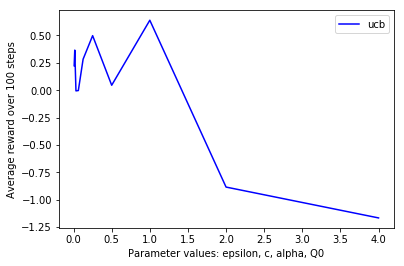

In [32]:
plot_bandits_parameter_comparison(bandits_parameter_comparison)